In [1]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin, OneToOneFeatureMixin
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve

In [2]:
df = pd.read_csv('dataset/space.csv')
df.tail()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
8688,9274_01,NaN,True,G/1508/P,TRAPPIST-1e,23.0,False,0.0,0.0,0.0,0.0,0.0,Chelsa Bullisey,True
8689,9275_01,Europa,False,A/97/P,TRAPPIST-1e,0.0,False,0.0,0.0,0.0,0.0,0.0,Polaton Conable,True
8690,9275_03,Europa,NaN,A/97/P,TRAPPIST-1e,30.0,False,0.0,3208.0,0.0,2.0,330.0,Atlasym Conable,True
8691,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8692,9280_02,Europa,False,E/608/S,TRAPPIST-1e,44.0,False,126.0,4688.0,0.0,0.0,12.0,Propsh Hontichre,True


In [3]:
# Custom transformer for splitting 'Cabin' feature
class CabinSplitter(BaseEstimator, TransformerMixin, OneToOneFeatureMixin):
    def __init__(self):
        return
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        cabin_df = X['Cabin'].fillna('Unknown/0/Unknown').str.split('/', expand=True)
        cabin_df.columns = ['Cabin_Deck', 'Cabin_Num', 'Cabin_Side']
        return cabin_df
        
    def get_feature_names_out(self):
        return self.columns

In [4]:
#preprocessing pipelines
numeric_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
categorical_features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']
cabin_feature = ['Cabin'] 

# Num pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Cat pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Cabin pipeline
cabin_transformer = Pipeline(steps=[
    ('cabin_split', CabinSplitter()),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Full preprocessor pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('cabin', cabin_transformer, cabin_feature)
    ])

In [5]:
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['Age', 'RoomService', 'FoodCourt',
                                  'ShoppingMall', 'Spa', 'VRDeck']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['HomePlanet', 'CryoSleep', 'Destination',
                                  'VIP']),
                                ('cabin',
                                 Pipeline(steps=[('cabin_split',
                                                  CabinSplitter()),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Cabin'])])

In [6]:
from sklearn.model_selection import train_test_split

target = 'Transported'
X = df.drop(columns=[target, 'Name', 'PassengerId'])
y = df[target]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [7]:
logistic_pipeline = Pipeline(
    steps=[
        ("preprocessing", preprocessor),
        ("classifier", LogisticRegression(max_iter=100))
    ]
)

cross_val_score(logistic_pipeline, X_train, y_train, cv=5, scoring="f1_macro").mean()

0.7821822602801741

In [8]:
param_grid = {
    "classifier__C": [0.001, 0.001, 0.01, 0.1, 1, 10, 100],
    "classifier__penalty": ["l1", "l2"],
    "classifier__class_weight": ["balanced", None],
    "preprocessing__num__imputer__strategy": ["mean", "median"],
    "preprocessing__cat__imputer__strategy": ["most_frequent", "constant"],
    "classifier__solver": ["liblinear"]
}


from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(logistic_pipeline, param_distributions=param_grid, n_iter=84, cv=5, scoring="recall")
random_search.fit(X_train, y_train)

C:\Users\emmanuel.osademe\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
205 fits failed out of a total of 420.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
205 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\emmanuel.osademe\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\_encode.py", line 174, in _unique_python
    uniques = sorted(uniques_set)
              ^^^^^^^^^^^^^^^^^^^
TypeError: '<' not supported between instances of 'str' and 'bool'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\emmanuel.osademe\AppData\Local\anaconda3\Lib\site-packages\sklea

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['Age',
                                                                                'RoomService',
                                                                                'FoodCourt',
                                                                                'ShoppingMall',
                                                                                'Spa',
                                                                                'VRDeck']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('onehot',
                                                                                                OneHotEncoder(handle...
                                              LogisticRegression())]),
                   n_iter=84,
                   param_distributions={'classifier__C': [0.001, 0.001, 0.01,
                                                          0.1, 1, 10, 100],
                                        'classifier__class_weight': ['balanced',
                                                                     None],
                                        'classifier__penalty': ['l1', 'l2'],
                                        'classifier__solver': ['liblinear'],
                                        'preprocessing__cat__imputer__strategy': ['most_frequent',
                                                                                  'constant'],
                                        'preprocessing__num__imputer__strategy': ['mean',
                                                                                  'median']},
                   scoring='recall')

In [9]:
print("Best parameters found: ", random_search.best_params_)
print("Best recall score: ", random_search.best_score_)

Best parameters found:  {'preprocessing__num__imputer__strategy': 'mean', 'preprocessing__cat__imputer__strategy': 'most_frequent', 'classifier__solver': 'liblinear', 'classifier__penalty': 'l1', 'classifier__class_weight': 'balanced', 'classifier__C': 1}
Best recall score:  0.8087751871428187


In [10]:
y_pred = random_search.predict(X_test)
f1 = f1_score(y_test, y_pred, average="macro")
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print((f1, accuracy, precision, recall))
print(classification_report(y_test, y_pred))

(0.7969153218654093, 0.7971625766871165, 0.7890909090909091, 0.8194864048338368)
              precision    recall  f1-score   support

       False       0.81      0.77      0.79      1284
        True       0.79      0.82      0.80      1324

    accuracy                           0.80      2608
   macro avg       0.80      0.80      0.80      2608
weighted avg       0.80      0.80      0.80      2608



ROC AUC LOGREG:  0.8795943685235903


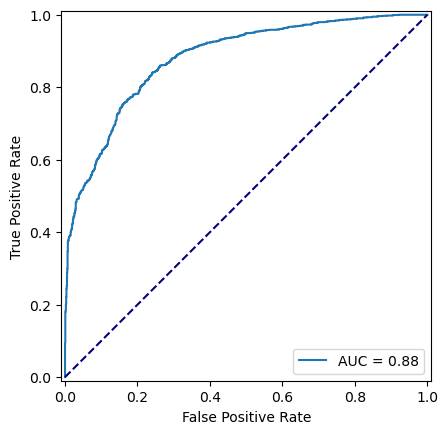

In [11]:
y_pred_prob = random_search.predict_proba(X_test)[:,1]
roc_auc_logreg = roc_auc_score(y_test, y_pred_prob)
print(f'ROC AUC LOGREG:  {roc_auc_logreg}')

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc_logreg)
roc_display.plot()
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.show()

In [12]:
knn_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', KNeighborsClassifier())
])

cross_val_score(knn_pipeline, X_train, y_train, cv=5, scoring="f1_macro").mean()

0.7653637114096457

In [13]:
param_grid = {
    "classifier__n_neighbors": [5, 10, 15, 20, 30, 50],
    "classifier__weights": ["uniform", "distance"],
    "classifier__p": [1, 2],  # Manhattan or Euclidean distance
    "preprocessing__num__imputer__strategy": ["mean", "median"],
    "preprocessing__cat__imputer__strategy": ["most_frequent", "constant"]
}

from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(
    knn_pipeline,
    param_distributions=param_grid,
    n_iter=96,  # safe as total space = 6 * 2 * 2 * 2 * 2 = 96
    cv=5,
    scoring="recall",
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

C:\Users\emmanuel.osademe\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
240 fits failed out of a total of 480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
237 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\emmanuel.osademe\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\_encode.py", line 174, in _unique_python
    uniques = sorted(uniques_set)
              ^^^^^^^^^^^^^^^^^^^
TypeError: '<' not supported between instances of 'str' and 'bool'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\emmanuel.osademe\AppData\Local\anaconda3\Lib\site-packages\sklea

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['Age',
                                                                                'RoomService',
                                                                                'FoodCourt',
                                                                                'ShoppingMall',
                                                                                'Spa',
                                                                                'VRDeck']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('onehot',
                                                                                                OneHotEncoder(handle...
                                             ('classifier',
                                              KNeighborsClassifier())]),
                   n_iter=96, n_jobs=-1,
                   param_distributions={'classifier__n_neighbors': [5, 10, 15,
                                                                    20, 30,
                                                                    50],
                                        'classifier__p': [1, 2],
                                        'classifier__weights': ['uniform',
                                                                'distance'],
                                        'preprocessing__cat__imputer__strategy': ['most_frequent',
                                                                                  'constant'],
                                        'preprocessing__num__imputer__strategy': ['mean',
                                                                                  'median']},
                   random_state=42, scoring='recall')

In [14]:
print("Best parameters found: ", random_search.best_params_)
print("Best recall score: ", random_search.best_score_)

Best parameters found:  {'preprocessing__num__imputer__strategy': 'median', 'preprocessing__cat__imputer__strategy': 'most_frequent', 'classifier__weights': 'distance', 'classifier__p': 1, 'classifier__n_neighbors': 20}
Best recall score:  0.7727600547342437


In [15]:
y_pred = random_search.predict(X_test)
f1 = f1_score(y_test, y_pred, average="macro")
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print((f1, accuracy, precision, recall))
print(classification_report(y_test, y_pred))

(0.7979270413960986, 0.7979294478527608, 0.8081979891724671, 0.7892749244712991)
              precision    recall  f1-score   support

       False       0.79      0.81      0.80      1284
        True       0.81      0.79      0.80      1324

    accuracy                           0.80      2608
   macro avg       0.80      0.80      0.80      2608
weighted avg       0.80      0.80      0.80      2608



ROC AUC LOGREG:  0.8803937727644917


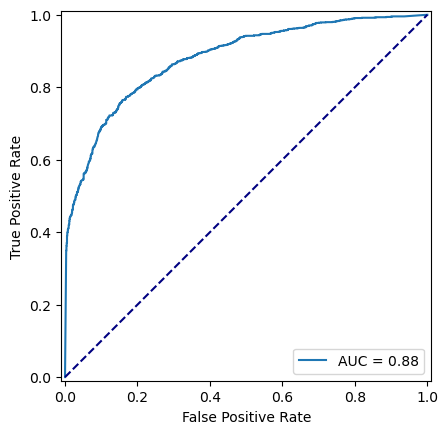

In [16]:
y_pred_prob = random_search.predict_proba(X_test)[:,1]
roc_auc_logreg = roc_auc_score(y_test, y_pred_prob)
print(f'ROC AUC LOGREG:  {roc_auc_logreg}')

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc_logreg)
roc_display.plot()
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.show()

In [17]:
xgb_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbosity=0))
])

In [18]:
param_grid = {
    "classifier__n_estimators": [100, 200, 300],
    "classifier__max_depth": [3, 5, 7, 10],
    "classifier__learning_rate": [0.01, 0.05, 0.1, 0.2],
    "classifier__subsample": [0.6, 0.8, 1.0],
    "classifier__colsample_bytree": [0.6, 0.8, 1.0],
    "classifier__gamma": [0, 1, 5],
    "classifier__reg_lambda": [1, 5, 10],
    "classifier__reg_alpha": [0, 0.5, 1],
    "preprocessing__num__imputer__strategy": ["mean", "median"],
    "preprocessing__cat__imputer__strategy": ["most_frequent", "constant"]
}

from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(
    xgb_pipeline,
    param_distributions=param_grid,
    n_iter=84,  # adjust as needed for performance
    cv=5,
    scoring="recall",
    random_state=42,
    n_jobs=-1,
    verbose=1
)

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 84 candidates, totalling 420 fits


C:\Users\emmanuel.osademe\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
200 fits failed out of a total of 420.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\emmanuel.osademe\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\_encode.py", line 174, in _unique_python
    uniques = sorted(uniques_set)
              ^^^^^^^^^^^^^^^^^^^
TypeError: '<' not supported between instances of 'bool' and 'str'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\emmanuel.osademe\AppData\Local\anaconda3\Lib\site-packages\sklearn

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['Age',
                                                                                'RoomService',
                                                                                'FoodCourt',
                                                                                'ShoppingMall',
                                                                                'Spa',
                                                                                'VRDeck']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('onehot',
                                                                                                OneHotEncoder(handle...
                                        'classifier__max_depth': [3, 5, 7, 10],
                                        'classifier__n_estimators': [100, 200,
                                                                     300],
                                        'classifier__reg_alpha': [0, 0.5, 1],
                                        'classifier__reg_lambda': [1, 5, 10],
                                        'classifier__subsample': [0.6, 0.8,
                                                                  1.0],
                                        'preprocessing__cat__imputer__strategy': ['most_frequent',
                                                                                  'constant'],
                                        'preprocessing__num__imputer__strategy': ['mean',
                                                                                  'median']},
                   random_state=42, scoring='recall', verbose=1)

In [19]:
print("Best parameters found: ", random_search.best_params_)
print("Best recall score: ", random_search.best_score_)

Best parameters found:  {'preprocessing__num__imputer__strategy': 'median', 'preprocessing__cat__imputer__strategy': 'most_frequent', 'classifier__subsample': 0.8, 'classifier__reg_lambda': 5, 'classifier__reg_alpha': 0, 'classifier__n_estimators': 300, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.05, 'classifier__gamma': 5, 'classifier__colsample_bytree': 1.0}
Best recall score:  0.8418394998792629


In [20]:
y_pred = random_search.predict(X_test)
f1 = f1_score(y_test, y_pred, average="macro")
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print((f1, accuracy, precision, recall))
print(classification_report(y_test, y_pred))

(0.7987523383880434, 0.7994631901840491, 0.778318276580959, 0.8459214501510574)
              precision    recall  f1-score   support

       False       0.83      0.75      0.79      1284
        True       0.78      0.85      0.81      1324

    accuracy                           0.80      2608
   macro avg       0.80      0.80      0.80      2608
weighted avg       0.80      0.80      0.80      2608



ROC AUC LOGREG:  0.8856954875718817


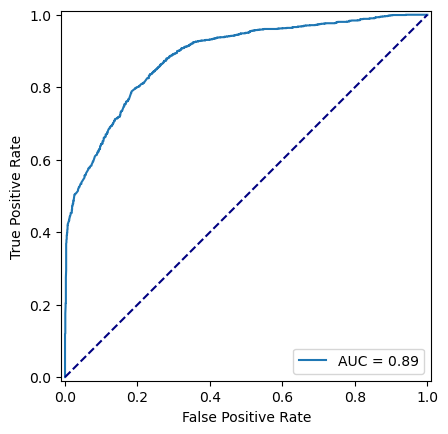

In [21]:
y_pred_prob = random_search.predict_proba(X_test)[:,1]
roc_auc_logreg = roc_auc_score(y_test, y_pred_prob)
print(f'ROC AUC LOGREG:  {roc_auc_logreg}')

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc_logreg)
roc_display.plot()
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.show()